# 2020年高教社杯全国大学生数学建模竞赛题目
# C题  中小微企业的信贷决策


*（请先阅读“全国大学生数学建模竞赛论文格式规范”）*

在实际中，由于中小微企业规模相对较小，也缺少抵押资产，因此银行通常是依据**信贷政策、企业的交易票据信息和上下游企业的影响力**，向**实力强、供求关系稳定**的企业提供贷款，并可以对**信誉高、信贷风险小**的企业给予利率优惠。银行首先根据中小微企业的**实力、信誉**对其信贷风险做出评估，然后**依据信贷风险等因素**来确定是否放贷及贷款额度、利率和期限等信贷策略。

某银行对确定要放贷企业的贷款额度为10-100 万元；年利率为4%-15%；贷款期限为1年。附件1~3分别给出了123家有信贷记录企业的相关数据、302家无信贷记录企业的相关数据和贷款利率与客户流失率关系的2019年统计数据。该银行请你们团队根据实际和附件中的数据信息，通过建立数学模型研究对中小微企业的信贷策略，主要解决下列问题：

1. 对附件1中123家企业的信贷风险进行量化分析，给出该银行在年度信贷总额固定时对这些企业的信贷策略。

2. 在问题1的基础上，对附件2中302家企业的信贷风险进行量化分析，并给出该银行在年度信贷总额为1亿元时对这些企业的信贷策略。

3. 企业的生产经营和经济效益可能会受到一些突发因素影响，而且突发因素往往对不同行业、不同类别的企业会有不同的影响。综合考虑附件2中各企业的信贷风险和可能的突发因素（例如：新冠病毒疫情）对各企业的影响，给出该银行在年度信贷总额为1亿元时的信贷调整策略。
 

+ **附件1  123家有信贷记录企业的相关数据**

+ **附件2  302家无信贷记录企业的相关数据**

+ **附件3  银行贷款年利率与客户流失率关系的2019年统计数据**

 

附件中数据说明：

1. 进项发票：企业进货（购买产品）时销售方为其开具的发票。

1. 销项发票：企业销售产品时为购货方开具的发票。

1. 有效发票：为正常的交易活动开具的发票。

1. 作废发票：在为交易活动开具发票后，因故取消了该项交易，使发票作废。

1. 负数发票：在为交易活动开具发票后，企业已入账记税，之后购方因故发生退货并退款，此时，需开具的负数发票。

1. 信誉评级：银行内部根据企业的实际情况人工评定的，银行对信誉评级为D的企业原则上不予放贷。

1. 客户流失率：因为贷款利率等因素银行失去潜在客户的比率。

## 一、对附件1中123家企业的信贷风险进行量化分析，给出该银行在年度信贷总额固定时对这些企业的信贷策略。

### 1. 数据处理
将**附件一**中

+ 1. 评级进行量化[A-80 B-60 C-40 D-20]（数据映射）
+ 2. 是否违约映射为 0，1（二分类）

当作要预测的目标，计算出企业进项总金额、企业销项总金额、企业总税额、企业进项数、企业销项数

In [1]:
# -*- coding: utf-8 -*-
"""
@author: EasternDay
"""
import pandas as pd

# 违约关系
debeyRule = {'否': 0, '是': 1}
degreeGrade = {'A': 80, 'B': 60, 'C': 40, 'D': 20}


# 读取csv文件
Company_info = pd.read_csv(
    "./数据/附件一_企业信息.csv", usecols=['企业代号', '企业名称', '信誉评级', '是否违约'])
Company_in = pd.read_csv(
    "./数据/附件一_进项发票信息.csv", usecols=['企业代号', '发票号码', '开票日期', '销方单位代号', '金额', '税额', '价税合计', '发票状态'])
Company_out = pd.read_csv(
    "./数据/附件一_销项发票信息.csv", usecols=['企业代号', '发票号码', '开票日期', '购方单位代号', '金额', '税额', '价税合计', '发票状态'])


Company_info['是否违约'] = Company_info['是否违约'].map(debeyRule)
Company_info['信誉评级'] = Company_info['信誉评级'].map(degreeGrade)

In [2]:
Company_info.head()

,企业代号,企业名称,信誉评级,是否违约
0,E1,***电器销售有限公司,80,0
1,E2,***技术有限责任公司,80,0
2,E3,***电子(中国)有限公司***分公司,40,0
3,E4,***发展有限责任公司,40,0
4,E5,***供应链管理有限公司,60,0


Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\84991\AppData\Local\Temp\jieba.cache
Loading model cost 0.729 seconds.
Prefix dict has been built successfully.


[('科技', 12), ('商贸', 9), ('劳务', 8), ('建筑', 7), ('工程', 6), ('建设工程', 5), ('装饰', 4), ('管理', 3), ('个体经营', 3), ('贸易', 3), ('建筑工程', 3), ('机械设备', 3), ('咨询', 3), ('经营部', 3), ('发展', 2)]


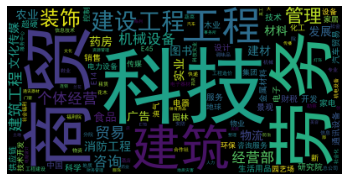

In [3]:
# 导入扩展库
import re # 正则表达式库
import collections # 词频统计库
import numpy as np # numpy数据处理库
import jieba # 结巴分词
import wordcloud # 词云展示库
from PIL import Image # 图像处理库
import matplotlib.pyplot as plt # 图像展示库

# 读取文件
string_data = Company_info['企业名称'].str.cat(sep=',')

# 文本预处理
pattern = re.compile(u'\t|\n|\.|-|:|;|\)|\(|\?|"') # 定义正则表达式匹配模式
string_data = re.sub(pattern, '', string_data) # 将符合模式的字符去除

# 文本分词
seg_list_exact = jieba.cut(string_data, cut_all = False) # 精确模式分词
object_list = []
remove_words = [u'*',u'有限',u',', u'，',u'责任', u'分公司', u'公司',u'有限责任',u'有限公司',u'（',u'）',u'(',u')'] # 自定义去除词库

for word in seg_list_exact: # 循环读出每个分词
    if word not in remove_words: # 如果不在去除词库中
        object_list.append(word) # 分词追加到列表

# 词频统计
word_counts = collections.Counter(object_list) # 对分词做词频统计
word_counts_top15 = word_counts.most_common(15) # 获取前10最高频的词
print (word_counts_top15) # 输出检查

# 词频展示
wc = wordcloud.WordCloud(
    font_path='C:/Windows/Fonts/simhei.ttf', # 设置字体格式
    max_words=200, # 最多显示词数
    max_font_size=100 # 字体最大值
)

wc.generate_from_frequencies(word_counts) # 从字典生成词云
plt.imshow(wc) # 显示词云
plt.axis('off') # 关闭坐标轴
plt.show() # 显示图像

### 2. 数据合并
+ 企业进项总金额
+ 企业销项总金额
+ 企业总税额
+ 企业进项数
+ 企业销项数
+ 作废发票数

In [4]:
def getIn(id):
    data_in = Company_in[(Company_in["企业代号"] == id) &
                         (Company_in["发票状态"] == "有效发票")]
    return data_in["金额"].sum()


def getInVar(id):
    data_in = Company_in[(Company_in["企业代号"] == id) &
                         (Company_in["发票状态"] == "有效发票")]
    return data_in["金额"].var()


def getOut(id):
    data_out = Company_out[(Company_out["企业代号"] == id)
                           & (Company_out["发票状态"] == "有效发票")]
    return data_out["金额"].sum()


def getOutVar(id):
    data_out = Company_out[(Company_out["企业代号"] == id)
                           & (Company_out["发票状态"] == "有效发票")]
    return data_out["金额"].var()


def getProfit(id):
    data_in = Company_in[(Company_in["企业代号"] == id) &
                         (Company_in["发票状态"] == "有效发票")]
    data_out = Company_out[(Company_out["企业代号"] == id)
                           & (Company_out["发票状态"] == "有效发票")]
    return data_out["税额"].sum() - data_in["税额"].sum()


def getInNumber(id):
    data_in = Company_in[(Company_in["企业代号"] == id) &
                         (Company_in["发票状态"] == "有效发票")]
    return data_in.shape[0]


def getOutNumber(id):
    data_out = Company_out[(Company_out["企业代号"] == id)
                           & (Company_out["发票状态"] == "有效发票")]
    return data_out.shape[0]


def getUselessNumber(id):
    data_in = Company_in[(Company_in["企业代号"] == id) &
                         (Company_in["发票状态"] == "作废发票")]
    data_out = Company_out[(Company_out["企业代号"] == id)
                           & (Company_out["发票状态"] == "作废发票")]
    return data_out.shape[0]+data_in.shape[0]


# 使用apply函数, 如果city字段包含'ing'关键词，则'判断'这一列赋值为1,否则为0
Company_info['进项总金额'] = Company_info["企业代号"].apply(lambda x: getIn(x))
#Company_info['进项金额方差'] = Company_info["企业代号"].apply(lambda x: getInVar(x))
Company_info['销项总金额'] = Company_info["企业代号"].apply(lambda x: getOut(x))
#Company_info['销项金额方差'] = Company_info["企业代号"].apply(lambda x: getOutVar(x))
Company_info['总税额'] = Company_info["企业代号"].apply(lambda x: getProfit(x))
Company_info['进项数'] = Company_info["企业代号"].apply(lambda x: getInNumber(x))
Company_info['销项数'] = Company_info["企业代号"].apply(lambda x: getOutNumber(x))
Company_info['作废数'] = Company_info["企业代号"].apply(lambda x: getUselessNumber(x))
Company_info['进项数'].astype("float")
Company_info['销项数'].astype("float")
Company_info['作废数'].astype("float")
Company_info['作废比例'] = Company_info.apply(
    lambda x: x['作废数']/(x['进项数']+x["销项数"]), axis=1)
Company_info
# Company_info.to_excel("信贷数据0.xlsx")  # 不保存行索引

,企业代号,企业名称,信誉评级,是否违约,进项总金额,销项总金额,总税额,进项数,销项数,作废数,作废比例
0,E1,***电器销售有限公司,80,0,5.744706e+09,4.065843e+09,-2.604456e+08,3249,7886,416,0.037360
1,E2,***技术有限责任公司,80,0,1.557623e+08,5.908417e+08,2.872827e+07,31435,11665,1763,0.040905
2,E3,***电子(中国)有限公司***分公司,40,0,5.202698e+07,5.701780e+08,8.873991e+07,4367,23688,579,0.020638
3,E4,***发展有限责任公司,40,0,2.198771e+08,1.839970e+09,2.718638e+08,521,2041,227,0.088603
4,E5,***供应链管理有限公司,60,0,1.977850e+08,2.026323e+08,1.111417e+06,2084,1005,140,0.045322
...,...,...,...,...,...,...,...,...,...,...,...
118,E119,***药房,20,1,2.197387e+05,3.567186e+04,-2.892597e+04,314,18,4,0.012048
119,E120,***陈列广告有限公司,20,1,1.811556e+04,1.906732e+05,4.389430e+03,35,9,21,0.477273
120,E121,***药业连锁有限公司***药店,20,1,1.073486e+06,1.014620e+05,-1.648082e+05,50,163,23,0.107981
121,E122,***商贸有限责任公司,20,1,5.067211e+04,5.892182e+04,-1.255370e+03,47,102,17,0.114094


In [5]:
def getMonthIn(id):
    data_in = Company_in[(Company_in["企业代号"] == id) &
                         (Company_in["发票状态"] == "作废发票")]
    data_in["开票日期"] = pd.to_datetime(data_in["开票日期"])
    return len(np.unique(data_in["开票日期"].dt.year.values))
def getMonthOut(id):
    data_out = Company_out[(Company_out["企业代号"] == id) &
                         (Company_out["发票状态"] == "作废发票")]
    data_out["开票日期"] = pd.to_datetime(data_out["开票日期"])
    return len(np.unique(data_out["开票日期"].dt.year.values))
Company_info['进项年数'] = Company_info["企业代号"].apply(lambda x: getMonthIn(x))
Company_info['销项年数'] = Company_info["企业代号"].apply(lambda x: getMonthOut(x))
Company_info

<ipython-input-5-3243cf24f10e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_in["开票日期"] = pd.to_datetime(data_in["开票日期"])
<ipython-input-5-3243cf24f10e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_out["开票日期"] = pd.to_datetime(data_out["开票日期"])


,企业代号,企业名称,信誉评级,是否违约,进项总金额,销项总金额,总税额,进项数,销项数,作废数,作废比例,进项年数,销项年数
0,E1,***电器销售有限公司,80,0,5.744706e+09,4.065843e+09,-2.604456e+08,3249,7886,416,0.037360,4,4
1,E2,***技术有限责任公司,80,0,1.557623e+08,5.908417e+08,2.872827e+07,31435,11665,1763,0.040905,4,4
2,E3,***电子(中国)有限公司***分公司,40,0,5.202698e+07,5.701780e+08,8.873991e+07,4367,23688,579,0.020638,4,4
3,E4,***发展有限责任公司,40,0,2.198771e+08,1.839970e+09,2.718638e+08,521,2041,227,0.088603,3,3
4,E5,***供应链管理有限公司,60,0,1.977850e+08,2.026323e+08,1.111417e+06,2084,1005,140,0.045322,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,E119,***药房,20,1,2.197387e+05,3.567186e+04,-2.892597e+04,314,18,4,0.012048,1,2
119,E120,***陈列广告有限公司,20,1,1.811556e+04,1.906732e+05,4.389430e+03,35,9,21,0.477273,1,1
120,E121,***药业连锁有限公司***药店,20,1,1.073486e+06,1.014620e+05,-1.648082e+05,50,163,23,0.107981,0,2
121,E122,***商贸有限责任公司,20,1,5.067211e+04,5.892182e+04,-1.255370e+03,47,102,17,0.114094,1,3


In [6]:
def getGoodMonthIn(id):
    data_in = Company_in[(Company_in["企业代号"] == id) &
                         (Company_in["发票状态"] == "作废发票")]
    data_in["开票日期"] = pd.to_datetime(data_in["开票日期"])
    data_in["年"] = data_in["开票日期"].dt.year.values
    data_in["月"] = data_in["开票日期"].dt.month.values
    return len(np.unique(data_in["月"].values))
def getGoodMonthOut(id):
    data_out = Company_out[(Company_out["企业代号"] == id) &
                         (Company_out["发票状态"] == "作废发票")]
    data_out["开票日期"] = pd.to_datetime(data_out["开票日期"])
    data_out["年"] = data_out["开票日期"].dt.year.values
    data_out["月"] = data_out["开票日期"].dt.month.values
    return len(np.unique(data_out["月"].values))
Company_info['进项月数'] = Company_info["企业代号"].apply(lambda x: getGoodMonthIn(x))
Company_info['销项月数'] = Company_info["企业代号"].apply(lambda x: getGoodMonthOut(x))
Company_info

<ipython-input-6-c4345e40ad80>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_in["开票日期"] = pd.to_datetime(data_in["开票日期"])
<ipython-input-6-c4345e40ad80>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_in["年"] = data_in["开票日期"].dt.year.values
<ipython-input-6-c4345e40ad80>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

,企业代号,企业名称,信誉评级,是否违约,进项总金额,销项总金额,总税额,进项数,销项数,作废数,作废比例,进项年数,销项年数,进项月数,销项月数
0,E1,***电器销售有限公司,80,0,5.744706e+09,4.065843e+09,-2.604456e+08,3249,7886,416,0.037360,4,4,12,12
1,E2,***技术有限责任公司,80,0,1.557623e+08,5.908417e+08,2.872827e+07,31435,11665,1763,0.040905,4,4,12,12
2,E3,***电子(中国)有限公司***分公司,40,0,5.202698e+07,5.701780e+08,8.873991e+07,4367,23688,579,0.020638,4,4,12,12
3,E4,***发展有限责任公司,40,0,2.198771e+08,1.839970e+09,2.718638e+08,521,2041,227,0.088603,3,3,12,9
4,E5,***供应链管理有限公司,60,0,1.977850e+08,2.026323e+08,1.111417e+06,2084,1005,140,0.045322,4,2,12,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,E119,***药房,20,1,2.197387e+05,3.567186e+04,-2.892597e+04,314,18,4,0.012048,1,2,1,2
119,E120,***陈列广告有限公司,20,1,1.811556e+04,1.906732e+05,4.389430e+03,35,9,21,0.477273,1,1,1,1
120,E121,***药业连锁有限公司***药店,20,1,1.073486e+06,1.014620e+05,-1.648082e+05,50,163,23,0.107981,0,2,0,7
121,E122,***商贸有限责任公司,20,1,5.067211e+04,5.892182e+04,-1.255370e+03,47,102,17,0.114094,1,3,1,6


### 3. 判断公司规模
+ 0租赁和商务服务业：商贸、劳务、机械设备、贸易、管理、咨询【8e7，1e6】
+ 1工业：装饰、工程、建筑、建设工程、建筑工程【2e7，3e6】
+ 2软件和信息技术服务业：科技【1e7，5e5】
+ 3其他：……【2e7，1e6】

In [7]:
def getCompanyType(id):
    a = re.findall(r'商贸|劳务|机械设备|贸易|管理|咨询|药|广告', id)
    b = re.findall(r'装饰|工程|建筑|建设|建筑|电子|电器|控制|机械|机电', id)
    c = re.findall(r'科技|信息|电脑|通讯', id)
    if(len(a) > 0):
        return 0
    if(len(b) > 0):
        return 1
    if(len(c) > 0):
        return 2
    return 3

"""
def getCompanyScale(x):
    type = x["公司类别"]
    money = max([x['进项总金额'], x['销项总金额']])
    if(type == 0):
        if(money >8e7):
            return 3
        elif(money>1e6):
            return 2
        else:
            return 1
    elif(type == 1):
        if(money >2e7):
            return 3
        elif(money>3e6):
            return 2
        else:
            return 1
    elif(type == 2):
        if(money >1e7):
            return 3
        elif(money>5e5):
            return 2
        else:
            return 1
    else:
        if(money >2e7):
            return 3
        elif(money>1e6):
            return 2
        else:
            return 1
            """

def getCompanyScale(x):
    type = x["公司类别"]
    money = max([x['进项总金额'], x['销项总金额']])
    if(money >1e7):
        return 3
    elif(money>5e5):
        return 2
    else:
        return 1

Company_info["公司类别"] = Company_info["企业名称"].apply(lambda x: getCompanyType(x))
Company_info["公司规模"] = Company_info.apply(lambda x: getCompanyScale(x),axis=1)
Company_info

,企业代号,企业名称,信誉评级,是否违约,进项总金额,销项总金额,总税额,进项数,销项数,作废数,作废比例,进项年数,销项年数,进项月数,销项月数,公司类别,公司规模
0,E1,***电器销售有限公司,80,0,5.744706e+09,4.065843e+09,-2.604456e+08,3249,7886,416,0.037360,4,4,12,12,1,3
1,E2,***技术有限责任公司,80,0,1.557623e+08,5.908417e+08,2.872827e+07,31435,11665,1763,0.040905,4,4,12,12,3,3
2,E3,***电子(中国)有限公司***分公司,40,0,5.202698e+07,5.701780e+08,8.873991e+07,4367,23688,579,0.020638,4,4,12,12,1,3
3,E4,***发展有限责任公司,40,0,2.198771e+08,1.839970e+09,2.718638e+08,521,2041,227,0.088603,3,3,12,9,3,3
4,E5,***供应链管理有限公司,60,0,1.977850e+08,2.026323e+08,1.111417e+06,2084,1005,140,0.045322,4,2,12,8,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,E119,***药房,20,1,2.197387e+05,3.567186e+04,-2.892597e+04,314,18,4,0.012048,1,2,1,2,0,1
119,E120,***陈列广告有限公司,20,1,1.811556e+04,1.906732e+05,4.389430e+03,35,9,21,0.477273,1,1,1,1,0,1
120,E121,***药业连锁有限公司***药店,20,1,1.073486e+06,1.014620e+05,-1.648082e+05,50,163,23,0.107981,0,2,0,7,0,2
121,E122,***商贸有限责任公司,20,1,5.067211e+04,5.892182e+04,-1.255370e+03,47,102,17,0.114094,1,3,1,6,0,1


### 4. 供求关系是否稳定

In [8]:
def getCompanyIn(id):
    data_in = Company_in[(Company_in["企业代号"] == id) &
                         (Company_in["发票状态"] == "有效发票")]
    return list(set(data_in["销方单位代号"].tolist()))


def getCompanyOut(id):
    data_out = Company_out[(Company_out["企业代号"] == id) &
                           (Company_out["发票状态"] == "有效发票")]
    return list(set(data_out["购方单位代号"].tolist()))


Company_info['供应公司比重'] = Company_info.apply(
    lambda x: len(getCompanyIn(x["企业代号"]))/x["进项数"], axis=1)
Company_info['销售公司比重'] = Company_info.apply(
    lambda x: len(getCompanyOut(x["企业代号"]))/x["销项数"], axis=1)

Company_info

,企业代号,企业名称,信誉评级,是否违约,进项总金额,销项总金额,总税额,进项数,销项数,作废数,作废比例,进项年数,销项年数,进项月数,销项月数,公司类别,公司规模,供应公司比重,销售公司比重
0,E1,***电器销售有限公司,80,0,5.744706e+09,4.065843e+09,-2.604456e+08,3249,7886,416,0.037360,4,4,12,12,1,3,0.134195,0.044636
1,E2,***技术有限责任公司,80,0,1.557623e+08,5.908417e+08,2.872827e+07,31435,11665,1763,0.040905,4,4,12,12,3,3,0.115317,0.135362
2,E3,***电子(中国)有限公司***分公司,40,0,5.202698e+07,5.701780e+08,8.873991e+07,4367,23688,579,0.020638,4,4,12,12,1,3,0.130753,0.005699
3,E4,***发展有限责任公司,40,0,2.198771e+08,1.839970e+09,2.718638e+08,521,2041,227,0.088603,3,3,12,9,3,3,0.251440,0.012739
4,E5,***供应链管理有限公司,60,0,1.977850e+08,2.026323e+08,1.111417e+06,2084,1005,140,0.045322,4,2,12,8,0,3,0.188580,0.032836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,E119,***药房,20,1,2.197387e+05,3.567186e+04,-2.892597e+04,314,18,4,0.012048,1,2,1,2,0,1,0.054140,0.777778
119,E120,***陈列广告有限公司,20,1,1.811556e+04,1.906732e+05,4.389430e+03,35,9,21,0.477273,1,1,1,1,0,1,0.457143,0.666667
120,E121,***药业连锁有限公司***药店,20,1,1.073486e+06,1.014620e+05,-1.648082e+05,50,163,23,0.107981,0,2,0,7,0,2,0.220000,0.711656
121,E122,***商贸有限责任公司,20,1,5.067211e+04,5.892182e+04,-1.255370e+03,47,102,17,0.114094,1,3,1,6,0,1,0.468085,0.676471


### 5. 随机森林

重要性： [0.05699379 0.07087161 0.05473766 0.06637369 0.0890398  0.06821591
 0.06439616 0.04592355 0.07356768 0.05361723 0.10014601 0.05659248
 0.06022835 0.06876673 0.07052937]
 1) 销项月数                           0.100146
 2) 销项数                            0.089040
 3) 销项年数                           0.073568
 4) 销项总金额                          0.070872
 5) 销售公司比重                         0.070529
 6) 供应公司比重                         0.068767
 7) 作废数                            0.068216
 8) 进项数                            0.066374
 9) 作废比例                           0.064396
10) 公司规模                           0.060228
11) 进项总金额                          0.056994
12) 公司类别                           0.056592
13) 总税额                            0.054738
14) 进项月数                           0.053617
15) 进项年数                           0.045924


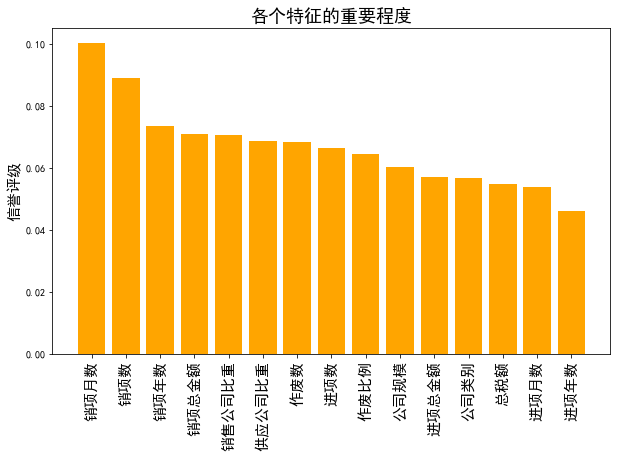

随机森林准确率 0.4864864864864865
随机森林精确率 0.4956349206349206
随机森林召回率 0.5263070263070263
F1 0.48975322922691344


In [9]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier


# 下面将数据集分为训练集和测试集
x, y = Company_info.iloc[:, 4:].values, Company_info.iloc[:, 2].values
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=0)
feat_labels = Company_info.columns[4:]

# n_estimators：森林中树的数量
# n_jobs  整数 可选（默认=1） 适合和预测并行运行的作业数，如果为-1，则将作业数设置为核心数
forest = ExtraTreesClassifier(n_estimators=10000, random_state=0, n_jobs=-1)
forest.fit(x_train, y_train)

# 下面对训练好的随机森林，完成重要性评估
# feature_importances_  可以调取关于特征重要程度
importances = forest.feature_importances_
print("重要性：", importances)
x_columns = Company_info.columns[4:]
indices = np.argsort(importances)[::-1]
x_columns_indices = []
for f in range(x_train.shape[1]):
    # 对于最后需要逆序排序，我认为是做了类似决策树回溯的取值，从叶子收敛
    # 到根，根部重要程度高于叶子。
    print("%2d) %-*s %f" %
          (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))
    x_columns_indices.append(feat_labels[indices[f]])

# print(x_columns_indices)
# print(x_columns.shape[0])
# print(x_columns)
# print(np.arange(x_columns.shape[0]))

# 筛选变量（选择重要性比较高的变量）
threshold = 0.15
x_selected = x_train[:, importances > threshold]

# 可视化
plt.figure(figsize=(10, 6))
plt.title("各个特征的重要程度", fontsize=18)
plt.ylabel("信誉评级", fontsize=15, rotation=90)
plt.rcParams['font.sans-serif'] = ["SimHei"]
plt.rcParams['axes.unicode_minus'] = False
for i in range(x_columns.shape[0]):
    plt.bar(i, importances[indices[i]], color='orange', align='center')
    plt.xticks(np.arange(x_columns.shape[0]),
               x_columns_indices, rotation=90, fontsize=15)
plt.show()


y_predict = forest.predict(x_test)
print('随机森林准确率', forest.score(x_test, y_test))
print('随机森林精确率', precision_score(y_test, y_predict,  average='macro'))
print('随机森林召回率', recall_score(y_test, y_predict,  average='macro'))
print('F1', f1_score(y_test, y_predict,  average='macro'))

In [10]:
import joblib
# 保存模型
joblib.dump(forest,'信誉分析.model')

['信誉分析.model']

重要性： [0.04898778 0.06289164 0.04614423 0.04607683 0.06742213 0.05997467
 0.07952148 0.03678455 0.07859963 0.05024109 0.13677402 0.05494005
 0.10766194 0.05328408 0.07069585]
 1) 销项月数                           0.136774
 2) 公司规模                           0.107662
 3) 作废比例                           0.079521
 4) 销项年数                           0.078600
 5) 销售公司比重                         0.070696
 6) 销项数                            0.067422
 7) 销项总金额                          0.062892
 8) 作废数                            0.059975
 9) 公司类别                           0.054940
10) 供应公司比重                         0.053284
11) 进项月数                           0.050241
12) 进项总金额                          0.048988
13) 总税额                            0.046144
14) 进项数                            0.046077
15) 进项年数                           0.036785


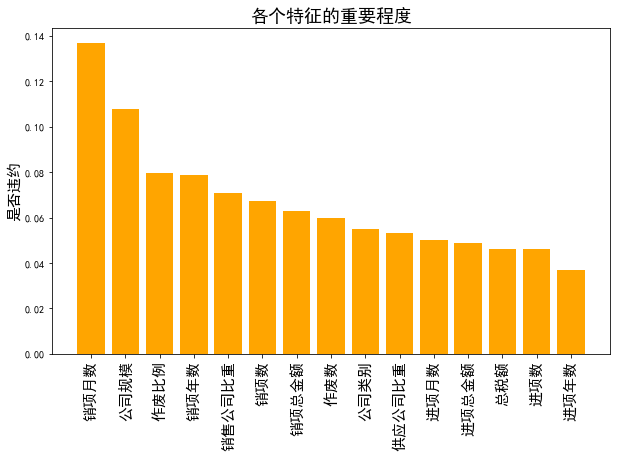

随机森林准确率 0.8648648648648649
随机森林精确率 0.8375
随机森林召回率 0.7327586206896552
F1 0.7667087011349306


In [11]:
# 下面将数据集分为训练集和测试集
x, y = Company_info.iloc[:, 4:].values, Company_info.iloc[:, 3].values
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=0)
feat_labels = Company_info.columns[4:]
# n_estimators：森林中树的数量
# n_jobs  整数 可选（默认=1） 适合和预测并行运行的作业数，如果为-1，则将作业数设置为核心数
forest = ExtraTreesClassifier(n_estimators=10000, random_state=0, n_jobs=-1)
forest.fit(x_train, y_train)

# 下面对训练好的随机森林，完成重要性评估
# feature_importances_  可以调取关于特征重要程度
importances = forest.feature_importances_
print("重要性：", importances)
x_columns = Company_info.columns[4:]
indices = np.argsort(importances)[::-1]
x_columns_indices = []
for f in range(x_train.shape[1]):
    # 对于最后需要逆序排序，我认为是做了类似决策树回溯的取值，从叶子收敛
    # 到根，根部重要程度高于叶子。
    print("%2d) %-*s %f" %
          (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))
    x_columns_indices.append(feat_labels[indices[f]])

# print(x_columns_indices)
# print(x_columns.shape[0])
# print(x_columns)
# print(np.arange(x_columns.shape[0]))

# 筛选变量（选择重要性比较高的变量）
threshold = 0.15
x_selected = x_train[:, importances > threshold]

# 可视化

plt.figure(figsize=(10, 6))
plt.title("各个特征的重要程度", fontsize=18)
plt.ylabel("是否违约", fontsize=15, rotation=90)
plt.rcParams['font.sans-serif'] = ["SimHei"]
plt.rcParams['axes.unicode_minus'] = False
for i in range(x_columns.shape[0]):
    plt.bar(i, importances[indices[i]], color='orange', align='center')
    plt.xticks(np.arange(x_columns.shape[0]),
               x_columns_indices, rotation=90, fontsize=15)
plt.show()

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

y_predict = forest.predict(x_test)
print('随机森林准确率',forest.score(x_test, y_test))
print('随机森林精确率',precision_score(y_test, y_predict,  average='macro'))
print('随机森林召回率',recall_score(y_test, y_predict,  average='macro'))
print('F1',f1_score(y_test, y_predict,  average='macro'))

In [12]:
import joblib
# 保存模型
joblib.dump(forest,'违约分析.model')

['违约分析.model']

## 6. 测试效果

In [13]:
Company_info['信贷风险'] = forest.predict(x)
Company_info.to_excel("信贷数据分析.xlsx") #不保存行索引
Company_info

,企业代号,企业名称,信誉评级,是否违约,进项总金额,销项总金额,总税额,进项数,销项数,作废数,作废比例,进项年数,销项年数,进项月数,销项月数,公司类别,公司规模,供应公司比重,销售公司比重,信贷风险
0,E1,***电器销售有限公司,80,0,5.744706e+09,4.065843e+09,-2.604456e+08,3249,7886,416,0.037360,4,4,12,12,1,3,0.134195,0.044636,0
1,E2,***技术有限责任公司,80,0,1.557623e+08,5.908417e+08,2.872827e+07,31435,11665,1763,0.040905,4,4,12,12,3,3,0.115317,0.135362,0
2,E3,***电子(中国)有限公司***分公司,40,0,5.202698e+07,5.701780e+08,8.873991e+07,4367,23688,579,0.020638,4,4,12,12,1,3,0.130753,0.005699,0
3,E4,***发展有限责任公司,40,0,2.198771e+08,1.839970e+09,2.718638e+08,521,2041,227,0.088603,3,3,12,9,3,3,0.251440,0.012739,0
4,E5,***供应链管理有限公司,60,0,1.977850e+08,2.026323e+08,1.111417e+06,2084,1005,140,0.045322,4,2,12,8,0,3,0.188580,0.032836,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,E119,***药房,20,1,2.197387e+05,3.567186e+04,-2.892597e+04,314,18,4,0.012048,1,2,1,2,0,1,0.054140,0.777778,1
119,E120,***陈列广告有限公司,20,1,1.811556e+04,1.906732e+05,4.389430e+03,35,9,21,0.477273,1,1,1,1,0,1,0.457143,0.666667,1
120,E121,***药业连锁有限公司***药店,20,1,1.073486e+06,1.014620e+05,-1.648082e+05,50,163,23,0.107981,0,2,0,7,0,2,0.220000,0.711656,1
121,E122,***商贸有限责任公司,20,1,5.067211e+04,5.892182e+04,-1.255370e+03,47,102,17,0.114094,1,3,1,6,0,1,0.468085,0.676471,1


### 7. 随机逻辑回归分析

c:\users\84991\appdata\local\programs\python\python38-32\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 20449 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\84991\appdata\local\programs\python\python38-32\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 35465 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\84991\appdata\local\programs\python\python38-32\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 35780 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\84991\appdata\local\programs\python\python38-32\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 32423 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\84991\appdata\local\programs\python\python38-32\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 26159 missing from current font.
  

c:\users\84991\appdata\local\programs\python\python38-32\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 36827 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\84991\appdata\local\programs\python\python38-32\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 39033 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\84991\appdata\local\programs\python\python38-32\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 24635 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\84991\appdata\local\programs\python\python38-32\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 37329 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\84991\appdata\local\programs\python\python38-32\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 39069 missing from current font.
  

c:\users\84991\appdata\local\programs\python\python38-32\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 38144 missing from current font.
  font.set_text(s, 0, flags=flags)
c:\users\84991\appdata\local\programs\python\python38-32\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 31246 missing from current font.
  font.set_text(s, 0, flags=flags)
c:\users\84991\appdata\local\programs\python\python38-32\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 25968 missing from current font.
  font.set_text(s, 0, flags=flags)
c:\users\84991\appdata\local\programs\python\python38-32\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 20316 missing from current font.
  font.set_text(s, 0, flags=flags)
c:\users\84991\appdata\local\programs\python\python38-32\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 24223 missing from current font.
  font.set

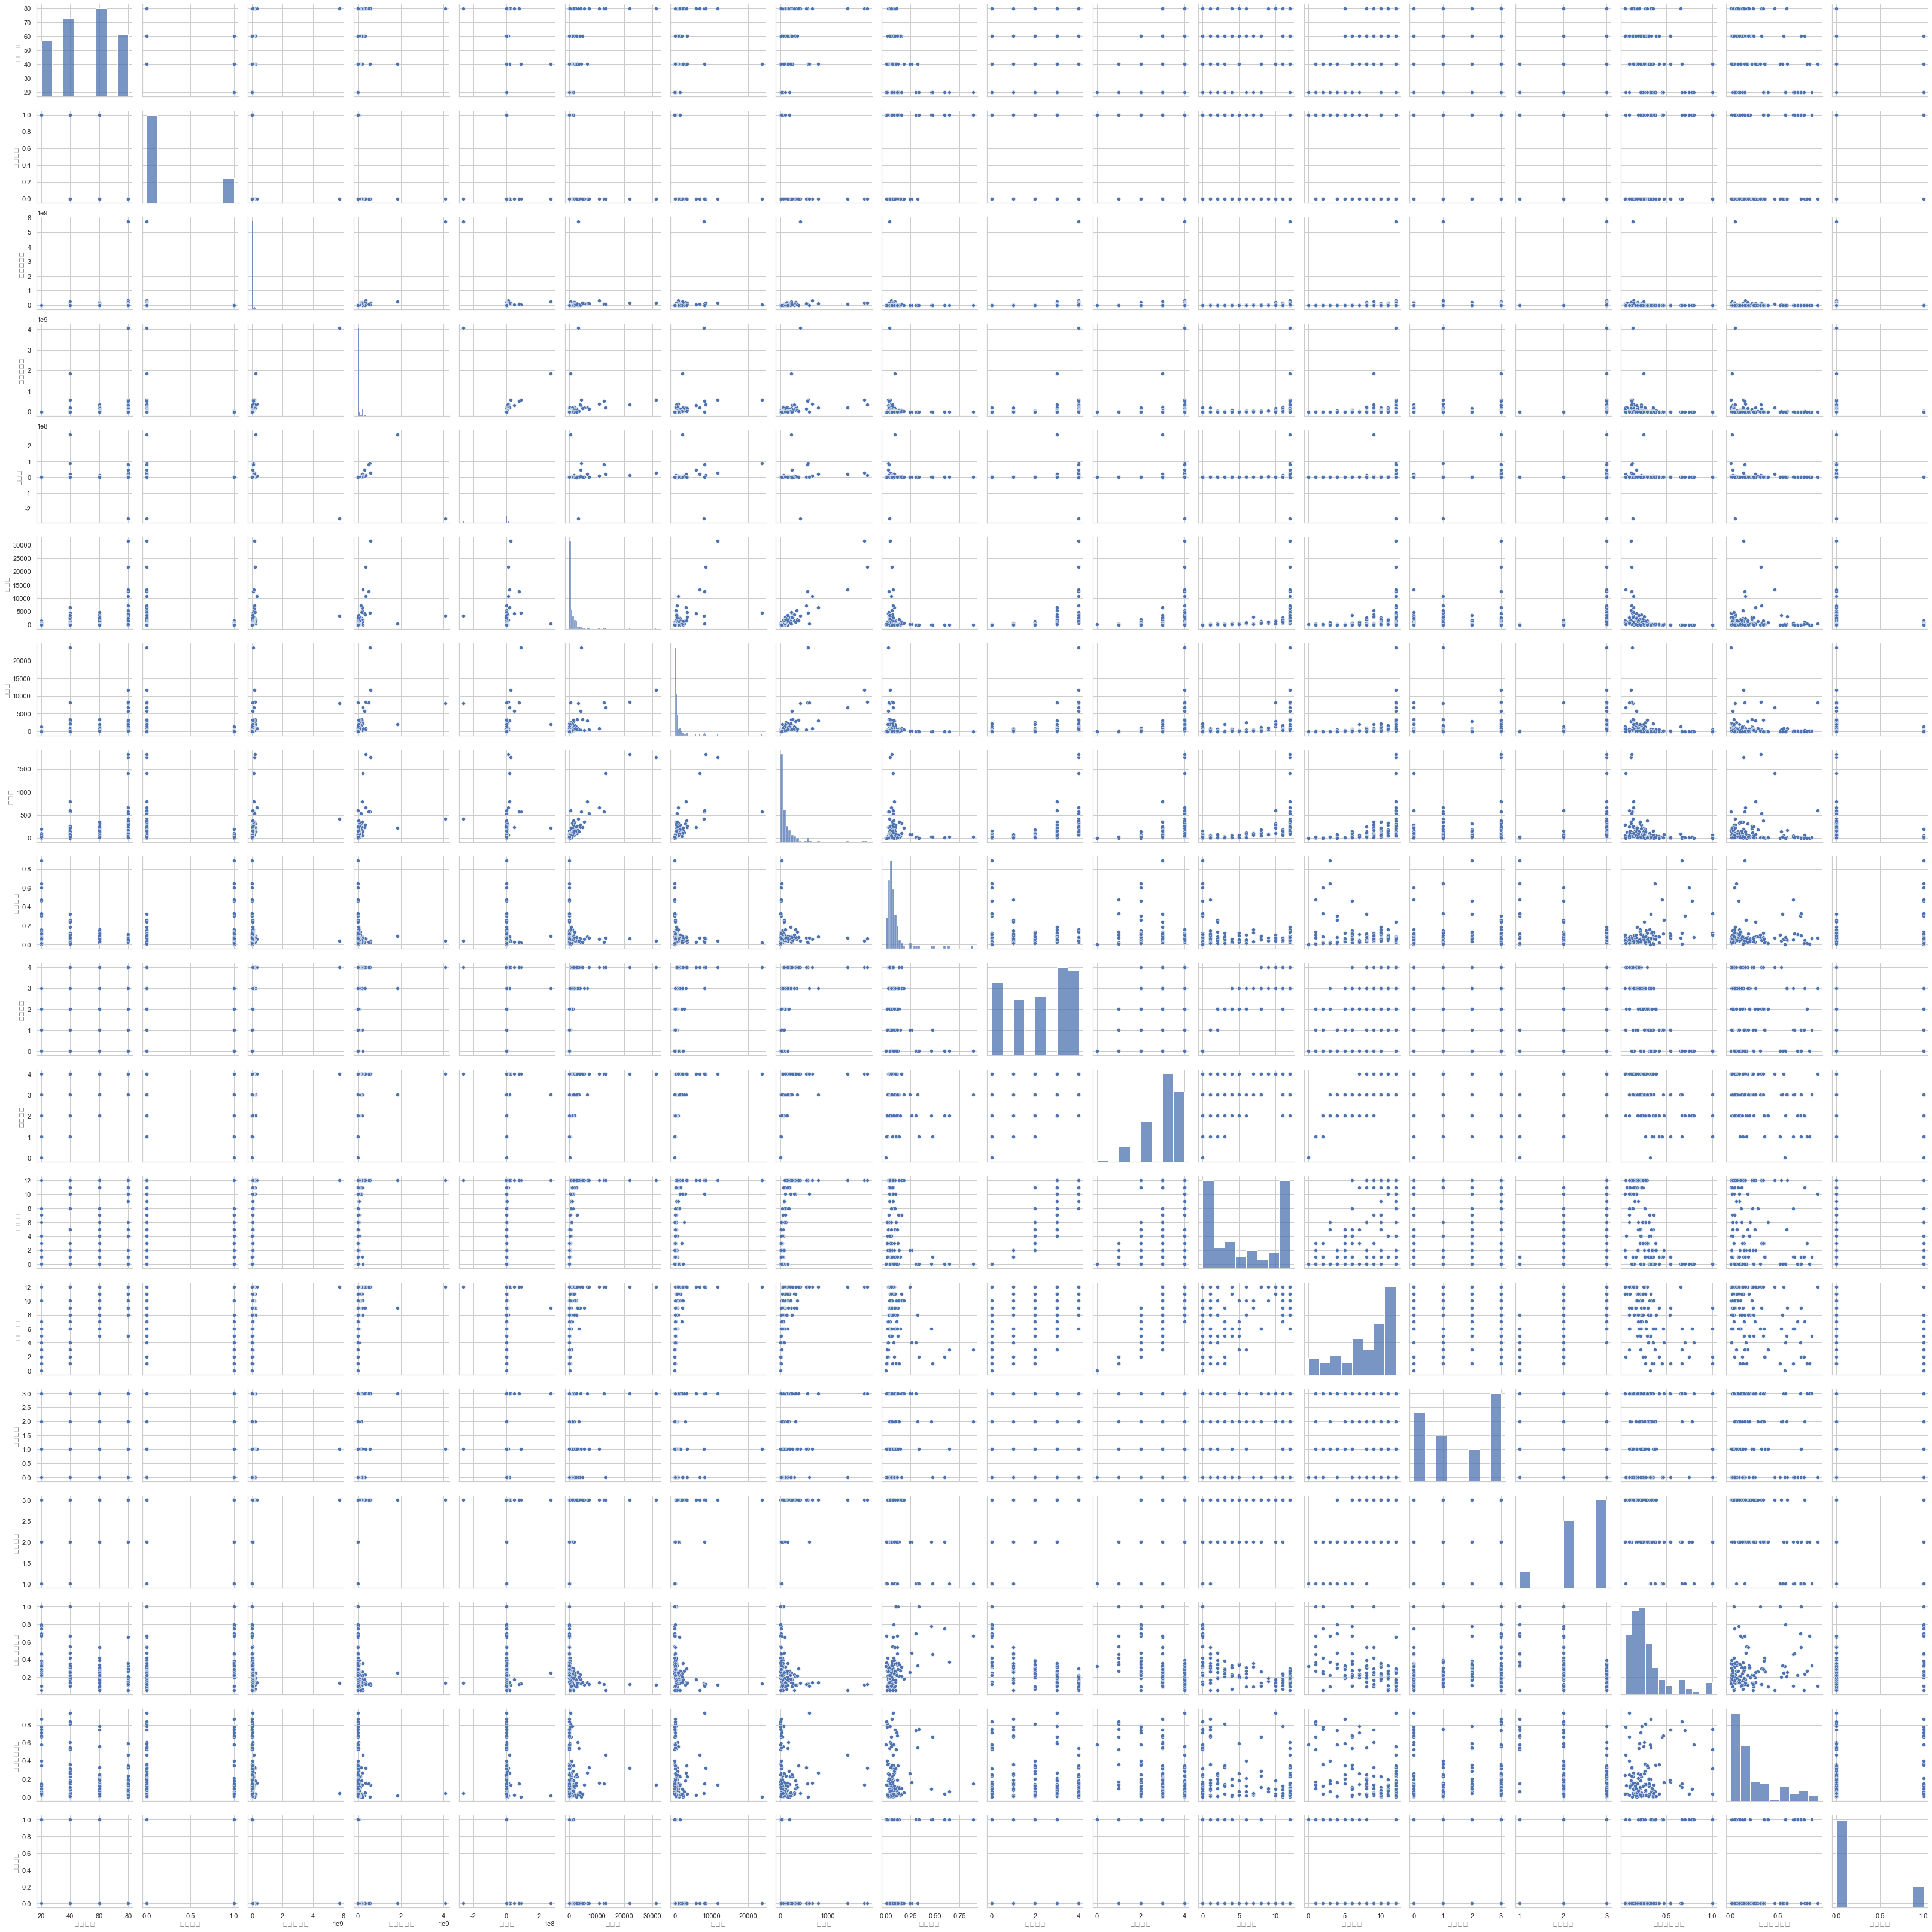

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["font.sans-serif"]=["SimHei"] #用来正常显示中文标签
plt.rcParams["axes.unicode_minus"]=False #用来正常显示负号
sns.set(style='whitegrid', context='notebook')   #style控制默认样式,context控制着默认的画幅大小
sns.pairplot(Company_info, height=2.5)
plt.tight_layout()
#plt.savefig('./scatter.png', dpi=300)
plt.show()